In [184]:
from __future__ import annotations
from typing import TypeVar, Generic, Any, Iterator
from dataclasses import dataclass, field
from enum import IntEnum, auto
from termcolor import colored
from graphviz import Digraph, nohtml
from abc import ABCMeta, abstractmethod
from functools import total_ordering

Cmp = TypeVar('Cmp', bound='Comparable')
@total_ordering
class Comparable(Generic[Cmp]):
    @abstractmethod
    def __lt__(self: Cmp, other: Any) -> bool: ...

    @abstractmethod
    def __gt__(self: Cmp, other: Cmp) -> bool: ...

T = TypeVar('T', int, Comparable)

In [185]:
class NodeColor(IntEnum):
    RED = auto()
    BLACK = auto()
    NIL = auto()


@dataclass
class Node(Generic[T]):
    value: T
    color: NodeColor = NodeColor.RED
    parent_: Node | None = field(default=None)

    def __post_init__(self):
        self.left: Node 
        self.right: Node 

        if self.color != NodeColor.NIL:
            # Nil nodes have dummy value None
            self.left = Node(value=None, color=NodeColor.NIL, parent_=self) # type: ignore
            self.right = Node(value=None, color=NodeColor.NIL, parent_=self) # type: ignore
    
    @property
    def is_nil(self) -> bool:
        return self.color == NodeColor.NIL

    @property
    def is_black(self) -> bool:
        return self.color in [NodeColor.BLACK, NodeColor.NIL]

    def is_full(self) -> bool:
        return not any([self.is_nil, self.left.is_nil, self.right.is_nil])

    def __str__(self) -> str:
        hl = 'on_magenta' if self.is_black else 'on_red'
        return colored(str(self.value), on_color=hl, attrs=['dark'])

    def in_order(self) -> Iterator[Node[T]]:
        if not self.is_nil:
            yield from self.left.in_order()
        yield self
        if not self.is_nil:
            yield from self.right.in_order()
    
    def insert(self, node: Node[T]) -> None:
        if self.is_nil:
            raise ValueError('Cannot insert into nil node')
        if node.value <= self.value:
            if self.left.is_nil:
                self.left = node
            else:
                self.left.insert(node)
        else:
            if self.right.is_nil:
                self.right = node
            else:
                self.right.insert(node)


In [186]:
class RBTree(Generic[T]):
    """
    1. Each node is either red or black.
    2. Root node must be black.
    3. All leaves must be black.
    4. Red nodes must have black children.
    5. Every path from a node to a descendant leaf contains the same number of black nodes.
    """
    def __init__(self, value: T) -> None:
        self.root = Node(value, NodeColor.BLACK)
    
    def __iter__(self) -> Iterator[Node]:
        yield from self.root.in_order()

    def __len__(self) -> int:
        return sum(1 for node in self if not node.is_nil)

    def insert(self, value: T) -> None:
        node = Node(value, color=NodeColor.RED)
        self.root.insert(node)
    
    def _repr_svg_(self) -> str:
        "repr to Jupyter Notebook"
        return self.graphviz()._repr_image_svg_xml()

    def graphviz(self, *args: Any, **kwargs: Any) -> Digraph:
        def style(color: str):
            return {'color': color, 'fillcolor': color}

        if "node_attr" not in kwargs:
            kwargs["node_attr"] = {
                "shape": "record",
                "style": "filled, rounded",
                "fontname": "Hack",
                "fontpath": "./asset/",
                "fontcolor": "white",
            }

        styles = { 
            NodeColor.RED: style('coral2'),
            NodeColor.BLACK: style('black'),
            NodeColor.NIL: style('gray16') | {'fixedsize':'true', 'width': '0.5', 'height': '0.3', 'magin': '0,0', 'fontsize': '8'} 
        }

        digraph = Digraph(*args, **kwargs)

        for node in self:
            node_id = str(id(node))
            digraph.node(node_id, nohtml(f"<l>|<v> {node.value}|<r>"), **styles[node.color])

            if not node.is_nil:
                digraph.edge(f"{node_id}:l", f"{id(node.left)}:v")
                digraph.edge(f"{node_id}:r", f"{id(node.right)}:v")

        return digraph

9


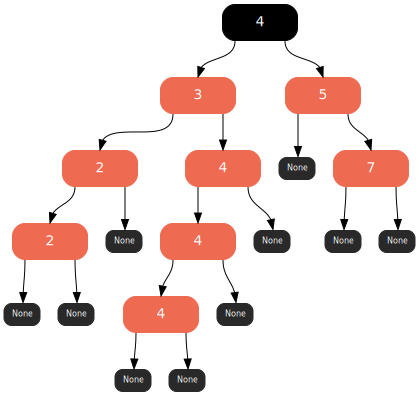

In [187]:
t = RBTree(4)
for n in [5, 7, 3, 2, 2, 4, 4, 4]:
    t.insert(n)
# t.root.left = Node(2, NodeColor.RED, parent_=t.root)
print(len(t))
t